# Cleaning and drop features

In [17]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from sklearn.preprocessing import LabelEncoder


In [18]:
df = pd.read_csv('../data/data_cleaned.csv', sep=',')

# encode target variable: 0: dropout, 1: enrolled, 2: graduated
le = LabelEncoder()
df['Target_encoded'] = le.fit_transform(df['Target'])

# Drop 'Target' variable
df.drop('Target', axis = 1, inplace = True)

# Change data types of columns that should be categorical
col = ['Marital_status', 'Application_mode', 'Course', 'Previous_qualification',
       'Mother_qualification', 'Father_qualification', 'Mother_occupation',
       'Father_occupation','Target_encoded']

df[col] = df[col].astype('category')


stud_selected = df.drop(['Nationality', 'International', 'Educational_special_needs'], axis = 1)  
stud_selected.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4424 entries, 0 to 4423
Data columns (total 34 columns):
 #   Column                                        Non-Null Count  Dtype   
---  ------                                        --------------  -----   
 0   Marital_status                                4424 non-null   category
 1   Application_mode                              4424 non-null   category
 2   Application_order                             4424 non-null   int64   
 3   Course                                        4424 non-null   category
 4   Daytime/evening_attendance                    4424 non-null   int64   
 5   Previous_qualification                        4424 non-null   category
 6   Previous_qualification_grade                  4424 non-null   float64 
 7   Mother_qualification                          4424 non-null   category
 8   Father_qualification                          4424 non-null   category
 9   Mother_occupation                             4424 n


| **Prestazione media**    Compatta le due note in un’unica metrica di qualità.     
                                                          
| **Efficienza**          Normalizzi per il numero di unità: evita che chi segue più corsi sembri “peggiore” solo perché ha più valutazioni. 

| **Trend / miglioramento** Cattura se lo studente recupera o peggiora; spesso è più predittivo del valore assoluto.    
                       
| **Carico di lavoro**  Indicatori di impegno complessivo, utili per dropout-risk.                                                         

| **Flag di rischio precoce**    Variabile binaria che riassume il primo semestre.                                                                  


quando due set di variabili sono altamente correlati perché misurano lo stesso concetto a momenti diversi, trasforma le seconde in segnali di progresso (differenze, rapporti, medie); spesso è l’andamento, non il valore assoluto, a distinguere chi si laurea da chi abbandona.

0 → 1: quanto lo studente si presenta davvero agli esami.

Delta > 0: migliora l’impegno; <br>
Delta < 0: cala (segnale di rischio).

# Features imbalanced

In [5]:
cat_cols = stud_selected.select_dtypes(include='category')

# Check the number of unique values in each categorical column
for col in cat_cols.columns:
    n_val = stud_selected[col].nunique()
    print(f"{col}: {n_val} unique values")

Marital_status: 6 unique values
Application_mode: 18 unique values
Course: 17 unique values
Previous_qualification: 17 unique values
Mother_qualification: 29 unique values
Father_qualification: 34 unique values
Mother_occupation: 32 unique values
Father_occupation: 46 unique values
Target_encoded: 3 unique values


In [4]:
def imbalance_report(df: pd.DataFrame, cat_columns, rare_thresh=0.01):
    """
    Return a DataFrame with imbalance metrics for each categorical column.
    - dominant_share: % of the most frequent category
    - rare_share    : total % of categories below `rare_thresh`
    - n_categories  : number of distinct categories
    """
    rows = []
    for col in cat_columns:
        freqs = df[col].value_counts(normalize=True, dropna=False)
        dominant_share = freqs.iloc[0]
        rare_share = freqs[freqs < rare_thresh].sum()
        rows.append({
            "feature": col,
            "dominant_share": dominant_share,
            "rare_share": rare_share,
            "n_categories": len(freqs)
        })
    return pd.DataFrame(rows).set_index("feature")           \
                             .sort_values("dominant_share", ascending=False)

imbalance_df = imbalance_report(stud_selected, cat_cols, rare_thresh=0.01)
print(imbalance_df.head(16))    # show the most skewed first


NameError: name 'cat_cols' is not defined

| `dominant_share ≥ 0.85` | Variabile dominata da un’unica modalità → alto rischio che le altre colonne “valgano zero”. 

| `rare_share ≥ 0.20`     | Molte modalità con frequenza < 1 % → sparsità elevata in one-hot, possibile over-fitting. 
  
| `n_categories ≫ 50`     | Cardinalità alta, anche se distribuzione non estrema.                                       


**COLLAPSE RARE LEVELS**

In [8]:
THRESH = 0.01          # share below which a level is considered "rare" (1 %)

cat_cols = []
for col in stud_selected.columns:
    if stud_selected[col].dtype.name in ["category"]:
        cat_cols.append(col)

print(f"Categorical columns detected ({len(cat_cols)}): {cat_cols}")

# -------------------------------------------------------------------
# 2) Collapse rare levels into the new code "0"
# -------------------------------------------------------------------
for col in cat_cols:
    # Ensure the column is of pandas 'category' dtype
    stud_selected[col] = stud_selected[col].astype("category")

    # Share of each level (NaNs kept separate)
    freqs = stud_selected[col].value_counts(normalize=True, dropna=False)
    rare_levels = freqs[freqs < THRESH].index

    # Skip columns with no rare levels
    if rare_levels.empty:
        continue

    # Add the new category code (0) if it doesn't exist yet
    if 0 not in stud_selected[col].cat.categories:
        stud_selected[col] = stud_selected[col].cat.add_categories([0])

    # Replace every rare level with 0
    stud_selected[col] = stud_selected[col].where(~stud_selected[col].isin(rare_levels), 0)

    # Optional: drop categories that disappeared after the replacement
    stud_selected[col] = stud_selected[col].cat.remove_unused_categories()

    print(f"Column '{col}': collapsed {len(rare_levels)} rare level(s) into 0")

# -------------------------------------------------------------------
# 3) (Optional) quick sanity-check
# -------------------------------------------------------------------
for col in cat_cols[:5]:   # inspect first 5 categorical columns
    print("\n", stud_selected[col].value_counts(normalize=True).head())


Categorical columns detected (9): ['Marital_status', 'Application_mode', 'Course', 'Previous_qualification', 'Mother_qualification', 'Father_qualification', 'Mother_occupation', 'Father_occupation', 'Target_encoded']
Column 'Marital_status': collapsed 3 rare level(s) into 0
Column 'Application_mode': collapsed 9 rare level(s) into 0
Column 'Course': collapsed 1 rare level(s) into 0
Column 'Previous_qualification': collapsed 12 rare level(s) into 0
Column 'Mother_qualification': collapsed 21 rare level(s) into 0
Column 'Father_qualification': collapsed 27 rare level(s) into 0
Column 'Mother_occupation': collapsed 22 rare level(s) into 0
Column 'Father_occupation': collapsed 34 rare level(s) into 0

 Marital_status
1    0.885850
2    0.085669
4    0.020570
0    0.007911
Name: proportion, dtype: float64

 Application_mode
1     0.386076
17    0.197107
39    0.177441
43    0.070524
44    0.048146
Name: proportion, dtype: float64

 Course
9500    0.173146
9147    0.085895
9238    0.080244
9

In [9]:
cat_columns = stud_selected.select_dtypes(include='category')

# Check the number of unique values in each categorical column
for col in cat_columns.columns:
    n_val = stud_selected[col].nunique()
    print(f"{col}: {n_val} unique values")

Marital_status: 4 unique values
Application_mode: 10 unique values
Course: 17 unique values
Previous_qualification: 6 unique values
Mother_qualification: 9 unique values
Father_qualification: 8 unique values
Mother_occupation: 10 unique values
Father_occupation: 12 unique values
Target_encoded: 3 unique values


# Data Splitting

In [30]:
from sklearn.model_selection import train_test_split

X = stud_selected.drop('Target_encoded', axis=1)  
y = stud_selected['Target_encoded']  

# Split the data into training and testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)

X_train shape: (3539, 33)
X_test shape: (885, 33)
y_train shape: (3539,)
y_test shape: (885,)


# Model comparison

1- FeaturesTrasformer (create new features)

2 - preprocessing (Standard Scaler, OneHot)

3- SelectPercentile (percentile=75, filtro per evitare overfitting)

4- RFECV / selectFromModel(alg tree-based)

5- SMOTE

5- model 

Provare con e senza feature selection

Decidere le metriche da valutare e stampare 

| Metrica               | Quando usarla                                   |
| --------------------- | ----------------------------------------------- |
| **Accuracy**          | Classi bilanciate, visione generale             |
| **F1-macro/Precision/Recall**          | Performance uguale su tutte le classi       |
| **F1-weighted/Precision/Recall**       | Se ti interessa anche il peso delle classi      |
| **Balanced Accuracy** | Quando ci sono classi sbilanciate         |
| **Confusion Matrix**  | Per capire dove sbaglia il modello          |
| **ROC AUC**           | Se lavori con probabilità e vuoi valutare curve |


precision_macro = media(precision per ciascuna classe) <br>
recall_macro = media(recall per ciascuna classe) <br>
f1_macro = media(F1 per ciascuna classe) 

precision_weighted = somma(precision_i * supporto_i) / totale


## Before features selection

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002533 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9522
[LightGBM] [Info] Number of data points in the train set: 4299, number of used features: 104
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002664 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9543
[LightGBM] [Info] Number of data points in the train set: 4299, number of used features: 108
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004486 sec

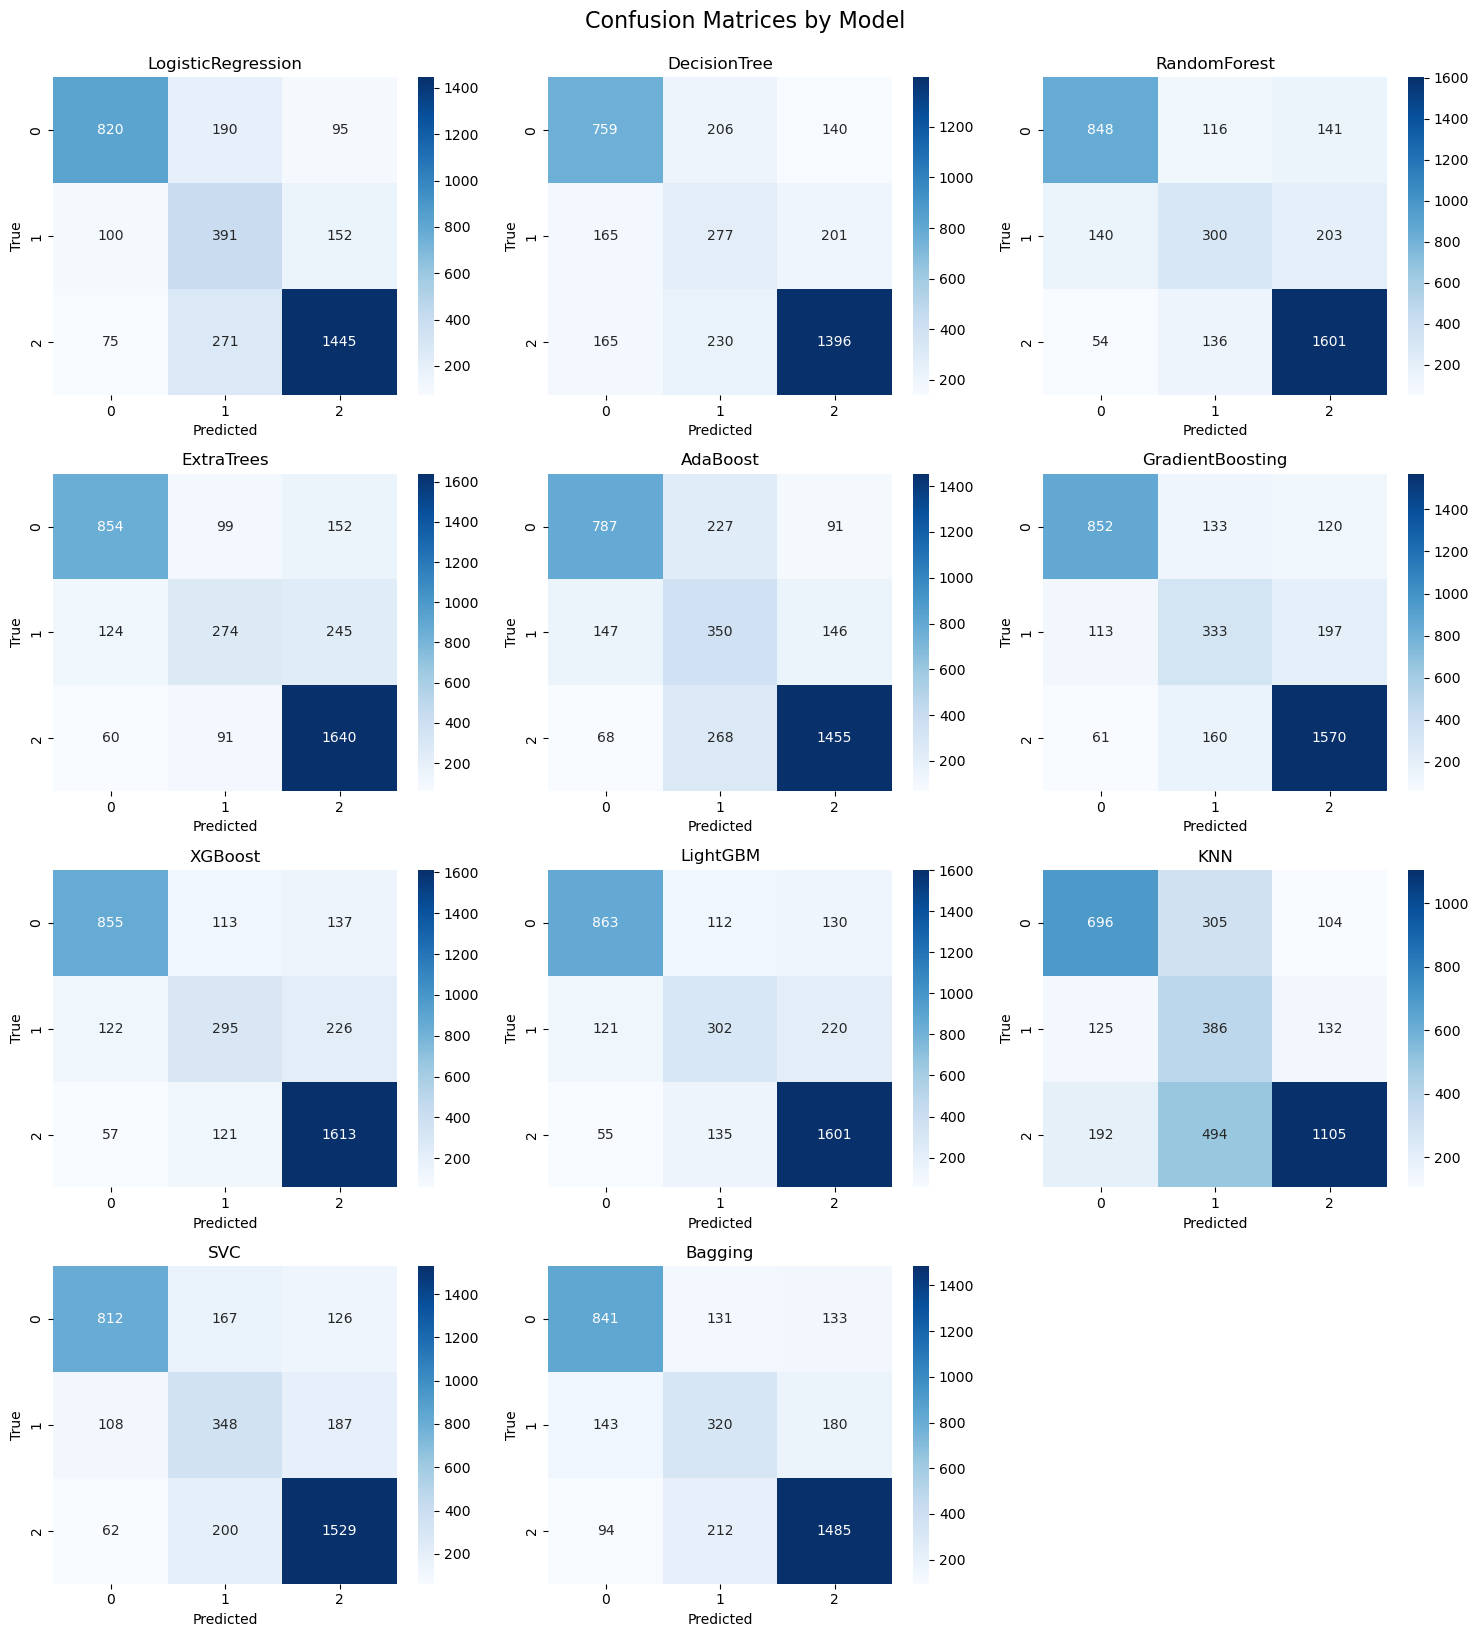

                 Model  Precision_macro  Recall_macro  F1_macro  \
5     GradientBoosting         0.731456      0.721844  0.726057   
7             LightGBM         0.733767      0.714861  0.722480   
6              XGBoost         0.733612      0.711052  0.719745   
2         RandomForest         0.726811      0.709299  0.716366   
3           ExtraTrees         0.739453      0.704889  0.716296   
0   LogisticRegression         0.712353      0.718993  0.711258   
9                  SVC         0.714558      0.709923  0.710799   
10             Bagging         0.696240      0.695966  0.696025   
4             AdaBoost         0.686520      0.689645  0.684317   
1         DecisionTree         0.629718      0.632375  0.630608   
8                  KNN         0.612273      0.615716  0.595054   

    Precision_weighted  Recall_weighted  F1_weighted  Balanced_Accuracy  \
5             0.776991         0.778468     0.777075           0.721844   
7             0.774578         0.781577     0

In [31]:
# Core libraries
from sklearn.model_selection import StratifiedKFold, cross_validate
from sklearn.metrics import make_scorer, f1_score

from imblearn.over_sampling import SMOTE
from imblearn.pipeline      import Pipeline

# Models
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import (RandomForestClassifier, ExtraTreesClassifier,
                              AdaBoostClassifier, GradientBoostingClassifier,
                              BaggingClassifier, VotingClassifier)
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

import pandas as pd
from sklearn.metrics import classification_report, confusion_matrix,  balanced_accuracy_score,  roc_auc_score
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np


from FeaturesTrasformer import FeaturesTransformer
from preprocessor import preprocessor

import warnings
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)



# --- Model 
models = {
    "LogisticRegression": LogisticRegression(),
    "DecisionTree": DecisionTreeClassifier(random_state=42),
    "RandomForest": RandomForestClassifier(random_state=42),
    "ExtraTrees": ExtraTreesClassifier(random_state=42),
    "AdaBoost": AdaBoostClassifier(random_state=42),
    "GradientBoosting": GradientBoostingClassifier(random_state=42),
    "XGBoost": XGBClassifier(random_state=42),
    "LightGBM": LGBMClassifier(random_state=42),
    "KNN": KNeighborsClassifier(),
    "SVC": SVC(kernel="rbf", probability=True),
    #"GaussianNB": GaussianNB(),
    "Bagging": BaggingClassifier(random_state=42)
    
}


skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Per salvare le confusion matrix
confusion_matrices = []
model_names = []

results_summary = []
detailed_results = []

for name, model in models.items():
    y_true_all = []
    y_pred_all = []
    y_prob_all = []

    for train_idx, test_idx in skf.split(X_train, y_train):
        X_fold_train = X_train.iloc[train_idx]
        y_fold_train = y_train.iloc[train_idx]
        X_fold_test = X_train.iloc[test_idx]
        y_fold_test = y_train.iloc[test_idx]

        pipeline = Pipeline(steps=[
            ('feature_transformer', FeaturesTransformer(drop_originals=True)),
            ('preprocessing', preprocessor),
            ('smote', SMOTE(random_state=42)),
            ('model', model)
        ])

        pipeline.fit(X_fold_train, y_fold_train)
        y_pred = pipeline.predict(X_fold_test)
        
        try:
            y_prob = pipeline.predict_proba(X_fold_test)
            y_prob_all.extend(y_prob)
        except:
            # Se il modello non supporta predict_proba
            y_prob_all = None

        y_true_all.extend(y_fold_test)
        y_pred_all.extend(y_pred)


    # Report + Balanced Accuracy
    report = classification_report(y_true_all, y_pred_all, output_dict=True, zero_division=0)
    bal_acc = balanced_accuracy_score(y_true_all, y_pred_all)

    # AUC
    auc_macro = np.nan
    auc_weighted = np.nan
    if y_prob_all is not None:
        try:
            auc_macro = roc_auc_score(y_true_all, np.array(y_prob_all), multi_class='ovr', average='macro')
            auc_weighted = roc_auc_score(y_true_all, np.array(y_prob_all), multi_class='ovr', average='weighted')
        except:
            pass

    results_summary.append({
        "Model": name,
        "Precision_macro": report['macro avg']['precision'],
        "Recall_macro": report['macro avg']['recall'],
        "F1_macro": report['macro avg']['f1-score'],
        "Precision_weighted": report['weighted avg']['precision'],
        "Recall_weighted": report['weighted avg']['recall'],
        "F1_weighted": report['weighted avg']['f1-score'],
        "Balanced_Accuracy": bal_acc,
        "AUC_macro": auc_macro,
        "AUC_weighted": auc_weighted
    })

    for label in report:
        if label not in ['accuracy', 'macro avg', 'weighted avg']:
            detailed_results.append({
                "Model": name,
                "Class": label,
                "Precision": report[label]['precision'],
                "Recall": report[label]['recall'],
                "F1-score": report[label]['f1-score'],
                "Support": report[label]['support']
            })

    cm = confusion_matrix(y_true_all, y_pred_all)
    confusion_matrices.append(cm)
    model_names.append(name)

# === Visualizza tutte le confusion matrix ===
n_models = len(confusion_matrices)
cols = 3
rows = (n_models + cols - 1) // cols

fig, axes = plt.subplots(rows, cols, figsize=(cols*5, rows*4))
axes = axes.flatten()

for i, cm in enumerate(confusion_matrices):
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", ax=axes[i])
    axes[i].set_title(f"{model_names[i]}")
    axes[i].set_xlabel("Predicted")
    axes[i].set_ylabel("True")

for j in range(i+1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.suptitle("Confusion Matrices by Model", fontsize=16, y=1.02)
plt.show()

# Mostra e salva i risultati
results_df = pd.DataFrame(results_summary).sort_values("F1_macro", ascending=False)
print(results_df)

detailed_df = pd.DataFrame(detailed_results)
print(detailed_df)


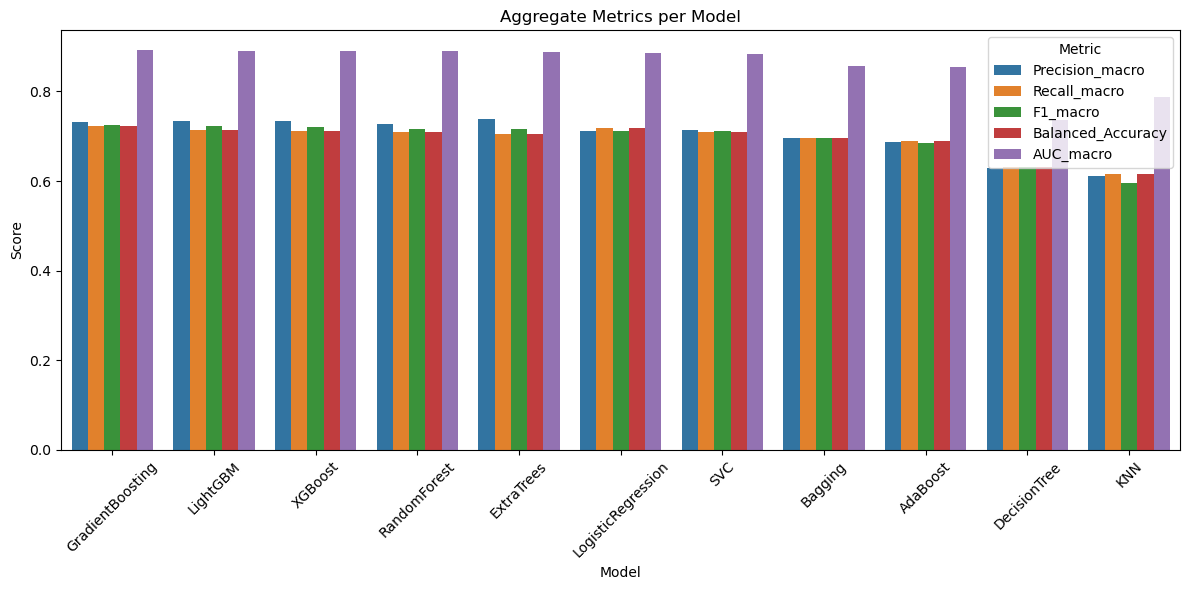

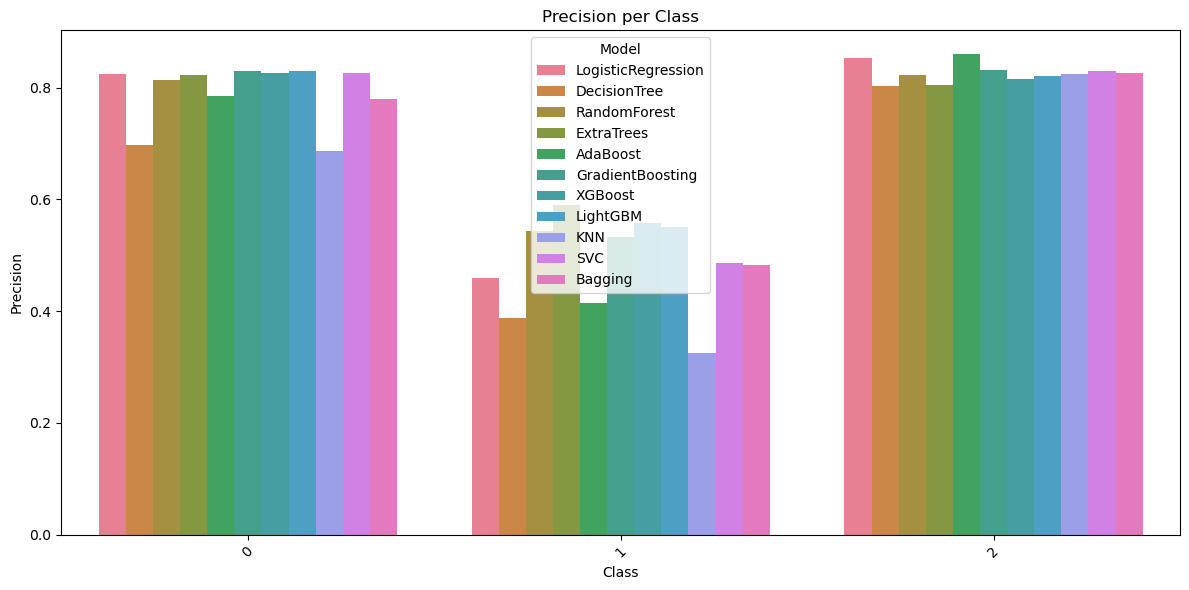

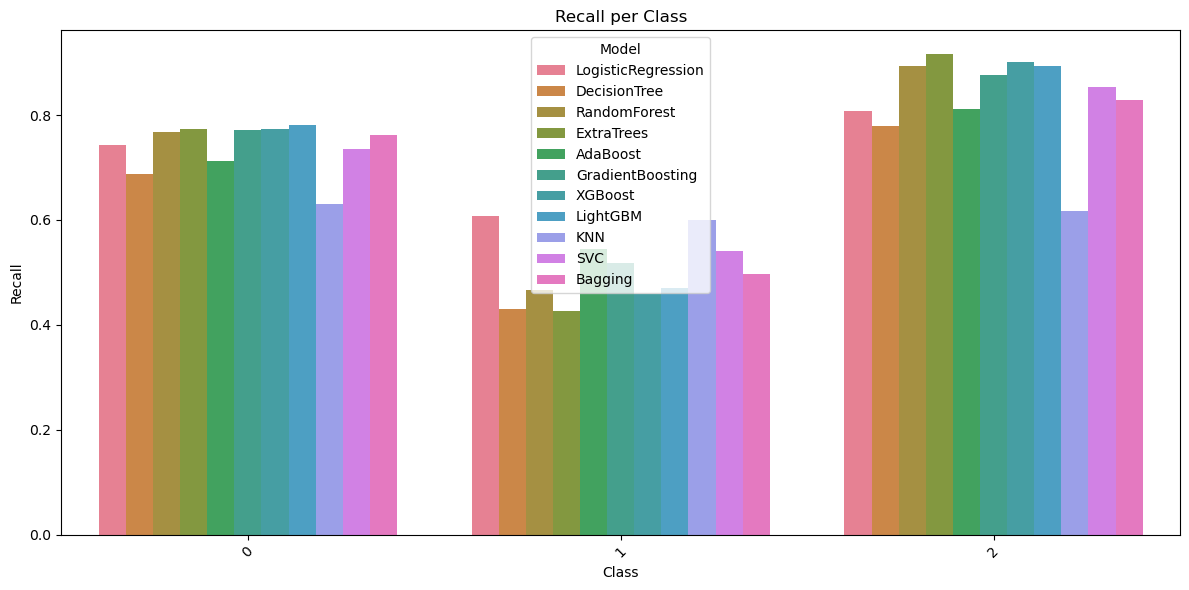

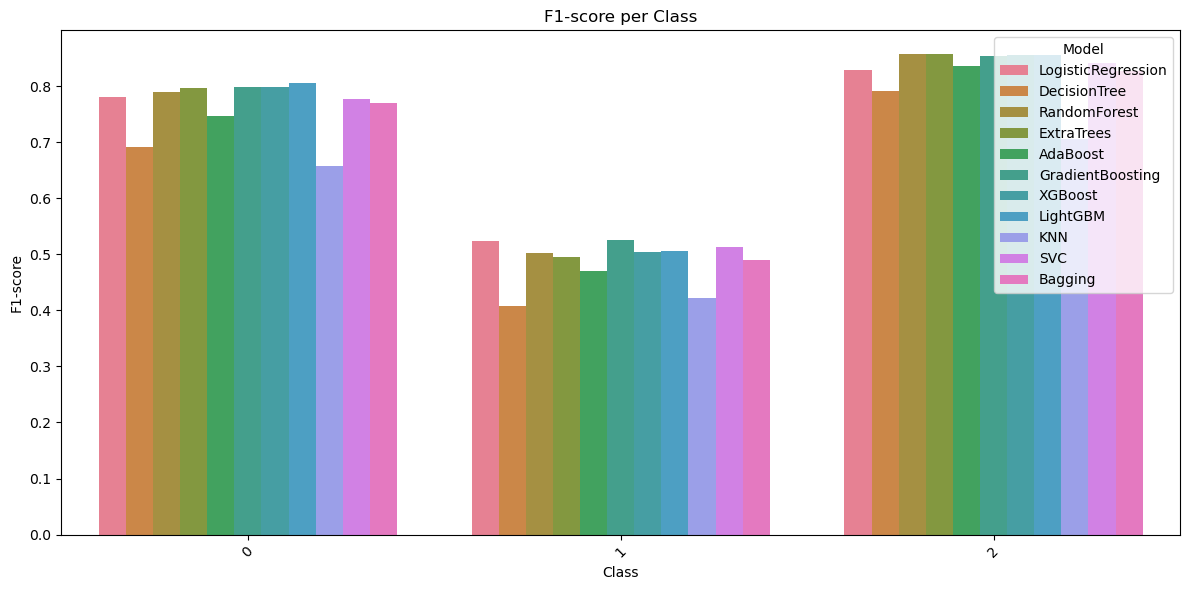

In [32]:

import matplotlib.pyplot as plt
import seaborn as sns

# Seleziona le metriche da visualizzare
metrics = ['Precision_macro', 'Recall_macro', 'F1_macro', 'Balanced_Accuracy','AUC_macro']
results_melted = results_df.melt(id_vars='Model', value_vars=metrics, var_name='Metric', value_name='Score')

plt.figure(figsize=(12, 6))
sns.barplot(data=results_melted, x='Model', y='Score', hue='Metric')
plt.xticks(rotation=45)
plt.title('Aggregate Metrics per Model')
plt.ylabel('Score')
plt.legend(title='Metric')
plt.tight_layout()
plt.show()


# Seleziona le metriche per classe
class_metrics = ['Precision', 'Recall', 'F1-score']
for metric in class_metrics:
    plt.figure(figsize=(12, 6))
    sns.barplot(data=detailed_df, x='Class', y=metric, hue='Model')
    plt.title(f'{metric} per Class')
    plt.ylabel(metric)
    plt.xticks(rotation=45)
    plt.legend(title='Model')
    plt.tight_layout()
    plt.show()
